# Benchmark de modelos


In [1037]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error

#Funcion para evaluar metricas del pronostico
def forecast_accuracy(forecast, actual, str_name, str_model):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    mae = np.mean(np.abs(forecast - actual))                 # MAE
    rmse = np.mean((forecast - actual)**2)**.5               # RMSE
    mse = np.mean((forecast - actual)**2)                    # MSE
    
    df_acc = pd.DataFrame({'model': str_model,
                           'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse]},
                          index=[str_name])
    
    return df_acc

## DATA

Inicialmente leemos las datos, considerando las observaciones y hallazgos encontrado en la exploración de los datos.

In [1038]:
data = pd.read_csv("../../data/consumo_silver.csv")
data.head()

,DateTime,CONSUMO,FESTIVO,TIPO_DIA,DIA_SEM,MES,AÑO,PANDEMIA
0,2014-01-01,1025.77354,Año_nuevo,FESTIVO,2,1,2014,0
1,2014-01-02,1478.33453,Normal,NORMAL,3,1,2014,0
2,2014-01-03,1610.05269,Normal,NORMAL,4,1,2014,0
3,2014-01-04,1578.83430,Normal,NORMAL,5,1,2014,0
4,2014-01-05,1328.31417,Normal,NORMAL,6,1,2014,0


In [1039]:
data.shape

(3796, 8)

### Selección de los datos

In [1040]:
df = data.loc[data["PANDEMIA"]==0]
df.reset_index(drop=True, inplace=True)
df = df.iloc[:-1]
timeserie = df["CONSUMO"]

In [1041]:
df.tail(10)

,DateTime,CONSUMO,FESTIVO,TIPO_DIA,DIA_SEM,MES,AÑO,PANDEMIA
3625,2024-05-13,1536.139170,Día_de_la_Ascensión_,FESTIVO,0,5,2024,0
3626,2024-05-14,1906.700781,Normal,NORMAL,1,5,2024,0
3627,2024-05-15,1980.639512,Normal,NORMAL,2,5,2024,0
3628,2024-05-16,1998.240820,Normal,NORMAL,3,5,2024,0
3629,2024-05-17,1989.789141,Normal,NORMAL,4,5,2024,0
3630,2024-05-18,1791.412832,Normal,NORMAL,5,5,2024,0
3631,2024-05-19,1594.514590,Normal,NORMAL,6,5,2024,0
3632,2024-05-20,1925.984277,Normal,NORMAL,0,5,2024,0
3633,2024-05-21,1939.075098,Normal,NORMAL,1,5,2024,0
3634,2024-05-22,1978.057168,Normal,NORMAL,2,5,2024,0


In [1042]:
timeserie

0       1025.773540
1       1478.334530
2       1610.052690
3       1578.834300
4       1328.314170
           ...     
3630    1791.412832
3631    1594.514590
3632    1925.984277
3633    1939.075098
3634    1978.057168
Name: CONSUMO, Length: 3635, dtype: float64

### División de los datos

In [1043]:
len_test = 15
len_val  = 15    

train = timeserie[:-(len_val + len_test)].copy()
val   = timeserie[-(len_val + len_test):-len_test].copy()
test  = timeserie[-len_test:].copy()

print(f"for Train: {len(train)}, for Validation: {len(val)}, for Test: {len(test)}")

for Train: 3605, for Validation: 15, for Test: 15


In [1044]:
test

3620    1955.510469
3621    1991.321211
3622    1989.661856
3623    1804.829043
3624    1468.677080
3625    1536.139170
3626    1906.700781
3627    1980.639512
3628    1998.240820
3629    1989.789141
3630    1791.412832
3631    1594.514590
3632    1925.984277
3633    1939.075098
3634    1978.057168
Name: CONSUMO, dtype: float64

## MODELOS

In [1045]:
#Aqui ingresare las metricas de todos los modelos
model_summary = pd.DataFrame()

### SUAVIZACION

In [1046]:
model = SimpleExpSmoothing(train).fit(smoothing_level=0.8, optimized=False)
model.forecast(15)

3605    1884.036876
3606    1884.036876
3607    1884.036876
3608    1884.036876
3609    1884.036876
3610    1884.036876
3611    1884.036876
3612    1884.036876
3613    1884.036876
3614    1884.036876
3615    1884.036876
3616    1884.036876
3617    1884.036876
3618    1884.036876
3619    1884.036876
dtype: float64

In [1047]:
def tes_optimizer(train, val, abg, trend, seasonal, seasonal_periods, step):
    best_params = {'alpha': None, 'beta': None, 'gamma': None, 'mae': float("inf")}
    
    for alpha, beta, gamma in abg:
        tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).\
            fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(val, y_pred)
        
        if mae < best_params['mae']:
            best_params.update({'alpha': alpha, 'beta': beta, 'gamma': gamma, 'mae': mae})
    
    return best_params['alpha'], best_params['beta'], best_params['gamma'], best_params['mae']



In [1048]:
def plot_model(train, val, test, y_pred, title):
    plt.figure(figsize=(10, 6))

    train[-300:].plot(legend=True, label="Train", color='blue', title=f"{title} - Train, Validation, Test and Prediction")
    val.plot(legend=True, label="Validation", color='orange')
    test.plot(legend=True, label="Test", color='green')
    y_pred.plot(legend=True, label="Prediction", color='red', style='--')

    mae = mean_absolute_error(test, y_pred)
    plt.title(f"{title}, MAE: {round(mae, 2)}")

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.show()

In [1049]:
def ses_optimizer(train, val, alphas, step):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(val, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

    return best_alpha, best_mae

In [1050]:
def ses_model_tuning(train, val, test, step, title="Model Tuning - Single Exponential Smoothing"):
    
    alphas = np.arange(0.8, 1, 0.01)
    best_alpha, best_mae = ses_optimizer(train, val, alphas, step=step)
    
    train_val = pd.concat([train, val])
    final_model = SimpleExpSmoothing(train_val).fit(smoothing_level=best_alpha, optimized=False)
    
    y_pred = final_model.forecast(step)
    mae = mean_absolute_error(test, y_pred)
    
    plot_model(train, val, test, y_pred, title)

    return y_pred

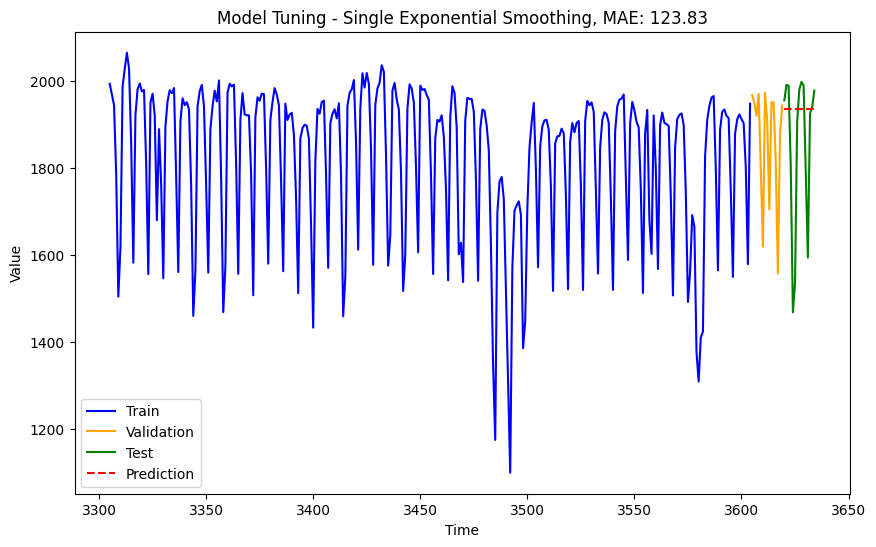

In [1051]:
pred = ses_model_tuning(train, val, test, step=15)

### Validación

In [1052]:
metrics = forecast_accuracy( np.array(pred), np.array(val), "val",  "SSE")
model_summary = pd.concat([model_summary, metrics])
metrics

,model,MAE,MSE,MAPE,RMSE
val,SSE,95.868582,22635.261372,0.056539,150.450196


### Testing

In [1053]:
metrics = forecast_accuracy( np.array(pred), np.array(test), "test",  "SSE")
model_summary = pd.concat([model_summary, metrics])
metrics

,model,MAE,MSE,MAPE,RMSE
test,SSE,123.83378,36805.83201,0.075663,191.848461


### ARIMA

In [1054]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px

### Autocorrelación y diferenciación 

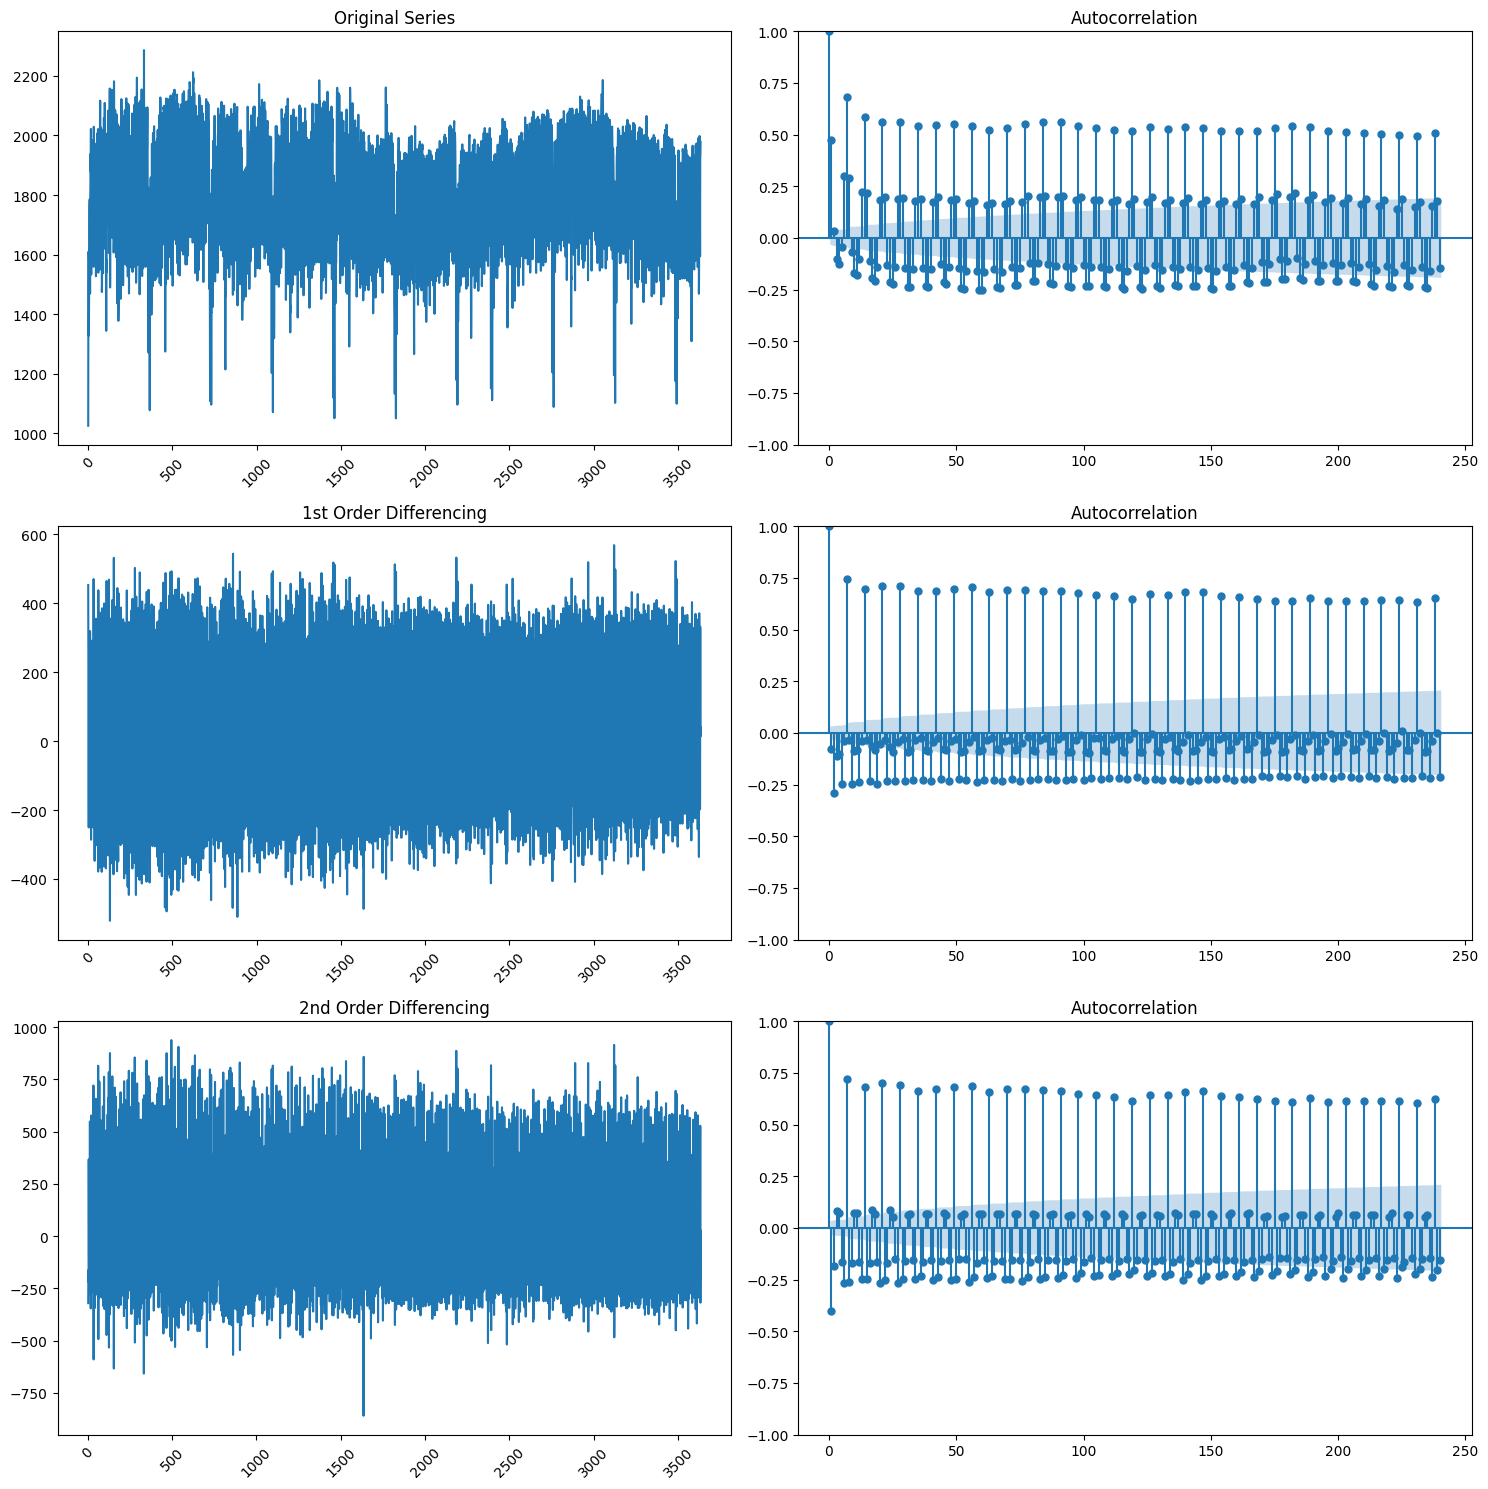

In [1055]:
plt.rcParams.update({'figure.figsize': (15,15)})

fig, axes = plt.subplots(3, 2)

# Serie original
axes[0, 0].plot(timeserie.index, timeserie)
axes[0, 0].set_title('Original Series')
#axes[0, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[0, 0].tick_params(axis='x', rotation=45)

plot_acf(timeserie, ax=axes[0, 1], lags=240)

# Primera diferencia
first_diff = timeserie.diff().dropna()
axes[1, 0].plot(first_diff.index, first_diff)
axes[1, 0].set_title('1st Order Differencing')
#axes[1, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1, 0].tick_params(axis='x', rotation=45)

plot_acf(first_diff, ax=axes[1, 1], lags=240)

# Segunda diferencia
second_diff = timeserie.diff().diff().dropna()
axes[2, 0].plot(second_diff.index, second_diff)
axes[2, 0].set_title('2nd Order Differencing')
#axes[2, 0].xaxis.set_major_locator(mdates.AutoDateLocator())
#axes[2, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[2, 0].tick_params(axis='x', rotation=45)

plot_acf(second_diff, ax=axes[2, 1], lags=240)

plt.tight_layout()
plt.show()

- Se podría considerar un ARIMA(p,1,q), dado que se aplicó una diferenciación de primer orden (d=1) para lograr la estacionariedad.

- La persistencia de autocorrelaciones sugiere que podrías necesitar explorar valores de p (componente autorregresiva) o q (componente de promedio móvil) para capturar estas dependencias.

- La diferenciación de segundo orden ha ayudado significativamente a que la serie sea estacionaria, al menos en términos de la tendencia. La mayoría de los valores en la ACF están dentro del rango de confianza, lo cual es un buen indicador.

- Dado que se ha aplicado dos diferenciaciones, puedes considerar un ARIMA(p,2,q), donde d=2 representa la diferenciación de segundo orden que se utilizó para lograr estacionariedad.

### Ajuste del modelo y parametros

In [1056]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

best_aic = np.inf
best_bic = np.inf

best_order = None
best_mdl = None

pq_rng = range(5)  # Posibles valores para p y q: [0, 1, 2, 3, 4]
d_rng  = range(1,3)  # Posibles valores para d: [0, 1, 2]

# Iterar sobre todas las combinaciones posibles de (p, d, q)
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                # Ajustar el modelo ARIMA con los parámetros (p, d, q)
                tmp_mdl = ARIMA(train, order=(i, d, j)).fit()
                tmp_aic = tmp_mdl.aic
                tmp_bic = tmp_mdl.bic

                # Evaluar el mejor modelo según AIC
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_bic = tmp_bic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl

            except Exception as e:
                print(f"Error con orden ({i}, {d}, {j}): {e}")  # Mostrar el error para diagnosticar problemas

# Imprimir el mejor orden encontrado
print(f"Mejor orden encontrado: {best_order} con AIC: {best_aic} y BIC: {best_bic}")

Mejor orden encontrado: (4, 1, 3) con AIC: 45998.35252599137 y BIC: 46047.8709229412


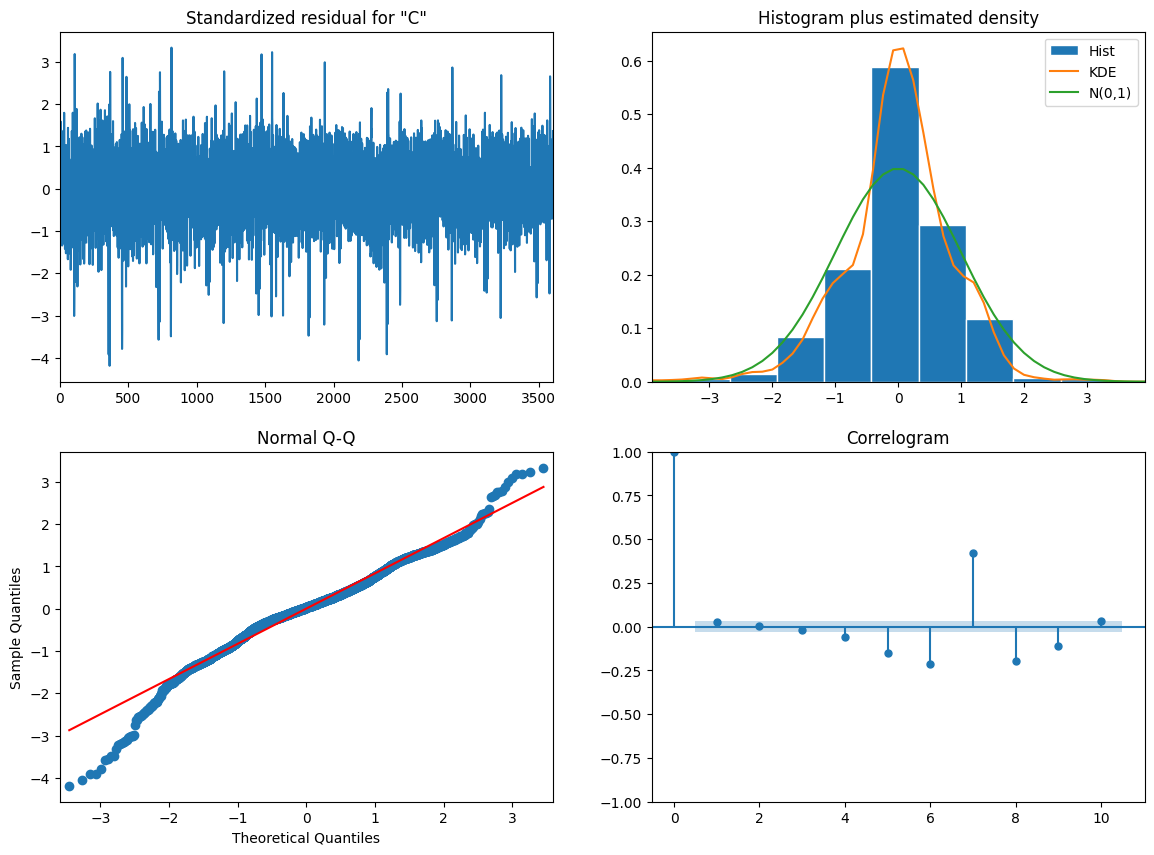

In [1057]:
from statsmodels.graphics.tsaplots import plot_predict
model = ARIMA(train, order= best_order)
model_fit = model.fit()
model_fit.plot_diagnostics(figsize=(14,10));

- Residuos no correlacionados: El correlograma indica que no hay una autocorrelación significativa en los residuos, lo cual es positivo y sugiere que el modelo ha capturado bien la dependencia temporal.

- Normalidad: Tanto el histograma como el gráfico Q-Q sugieren que los residuos son aproximadamente normales, aunque hay algunas ligeras desviaciones en las colas. Esto no suele ser un problema grave si las desviaciones no son muy grandes.

- Varianza constante: El gráfico de residuos estandarizados muestra una varianza constante y residuos centrados alrededor de cero, lo cual es una buena indicación de que el modelo ha capturado bien la estructura de la serie.

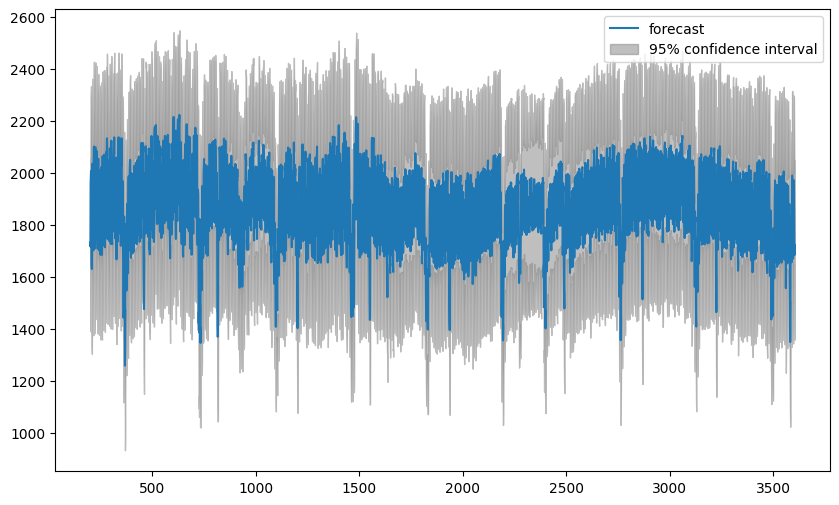

In [1058]:
plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots();
plot_predict(model_fit, 200, ax=ax);
plt.show();

### Validación

In [1059]:
forecast = model_fit.forecast(steps=15)
to_pred = val
metrics = forecast_accuracy(forecast, to_pred,'val','ARIMA_NO_ROLLING')
model_summary = pd.concat([model_summary, metrics])
metrics

,model,MAE,MSE,MAPE,RMSE
val,ARIMA_NO_ROLLING,91.592126,14909.387039,0.051193,122.104001


In [1060]:
residuals = forecast - to_pred
px.line(residuals)

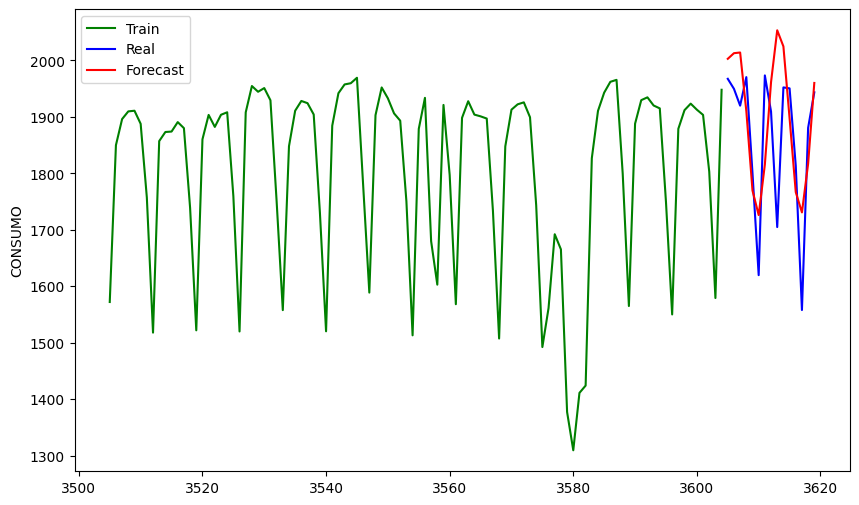

In [1061]:
import seaborn as sns
ax = sns.lineplot(x=train.index[-100:], y=train[-100:], label="Train", color='g')
sns.lineplot(x=to_pred.index, y=to_pred, label="Real", color='b')
sns.lineplot(x=to_pred.index, y=forecast, label="Forecast", color='r')
plt.show()

En el set de validación los errores presentados son minimos, en la magnitud de desviación estos se encuentran dentro de un rango tolerable para el proceso.

### Testing

In [1062]:
forecast = model_fit.forecast(steps=15)
metrics = forecast_accuracy(forecast, test.tolist(),'test', 'ARIMA_NO_ROLLING')
model_summary = pd.concat([model_summary, metrics])
metrics

,model,MAE,MSE,MAPE,RMSE
test,ARIMA_NO_ROLLING,100.278742,16553.63233,0.058523,128.66092


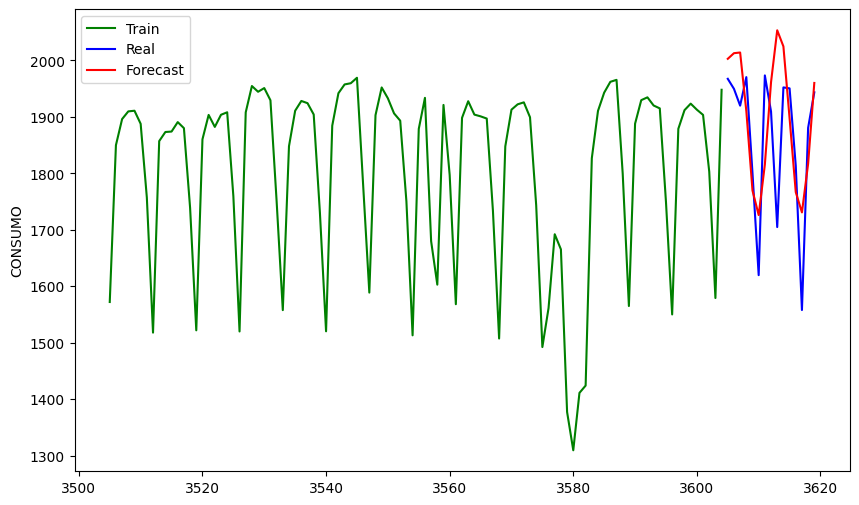

In [1063]:
ax = sns.lineplot(x=train.index[-100:], y=train[-100:], label="Train", color='g')
sns.lineplot(x=to_pred.index, y=to_pred, label="Real", color='b')
sns.lineplot(x=to_pred.index, y=forecast, label="Forecast", color='r')
plt.show()

Se observa que los errores del modelo aumentaron. Al analizar las magnitudes individuales, se puede observar que la ultima predicción tiene un residuo extremandamente alto en comparación de los demás, probablemente este dato sea un outlier en el consumo del día.

### ARIMA con Rolling

Utilizando el modelo ARIMA encontrado en el punto anterior, se utiliza la metodologia del rolling para tratar de mejorar las predicciones. Como se analizó en el EDA esta serie de tiempo es estacional cada semana, siendo los fines de semana con un marcado consumo bajo y los días habiles con un consumo más significativo. Por lo anterior, la ventana de rolling usada es de 7 dias

In [1064]:
def arima_rolling(history, test):
    predictions = list()
    for t in range(len(test)):
        try:
            model = ARIMA(history, order=best_order)
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
        except np.linalg.LinAlgError:
            print(f"LinAlgError at step {t}, using last observed value as prediction")
            yhat = history[-7]  # Puede ser cualquier valor que tenga sentido, como el último observado

        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))

    return predictions

**Set de validación**

In [1065]:
to_pred = val
to_train = train.tolist()
forecast  = arima_rolling(to_train, to_pred.tolist())
metrics = forecast_accuracy(np.array(forecast),np.array(to_pred), "val", 'ARIMA_ROLLING')
model_summary = pd.concat([model_summary, metrics])
metrics

predicted=2002.879492, expected=1967.459565
predicted=1999.305402, expected=1949.701685
predicted=1987.814753, expected=1919.920815
predicted=1867.638758, expected=1970.447813
predicted=1775.035441, expected=1800.073150
predicted=1699.218394, expected=1619.637617
predicted=1768.436613, expected=1973.480230
predicted=2027.082298, expected=1909.394285
predicted=1997.078504, expected=1704.837188
predicted=1917.549014, expected=1952.214453
predicted=1887.251516, expected=1950.548945
predicted=1707.578168, expected=1813.489492
predicted=1684.207802, expected=1557.859063
predicted=1722.731561, expected=1880.631797
predicted=1985.148161, expected=1943.488652


,model,MAE,MSE,MAPE,RMSE
val,ARIMA_ROLLING,100.34005,15080.678944,0.055073,122.803416


In [1066]:
residuals = np.array(forecast) - to_pred 
px.line(residuals)

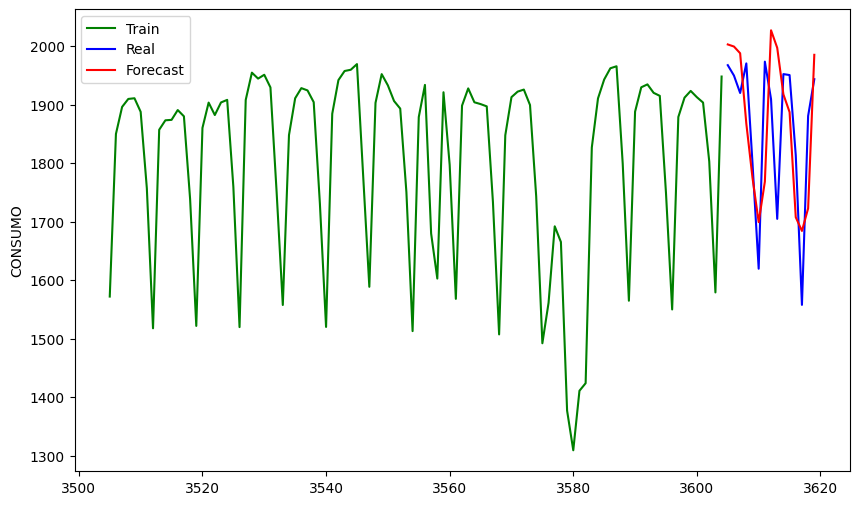

In [1067]:
ax = sns.lineplot(x=train.index[-100:], y=train[-100:], label="Train", color='g')
sns.lineplot(x=to_pred.index, y=to_pred, label="Real", color='b')
sns.lineplot(x=to_pred.index, y=forecast, label="Forecast", color='r')
plt.show()

Para el set de validación, se observa un MAE bajo de solo 99.89 que es similar al del ARIMA sin rolling donde era de 93.

**Desempeño en testing**

In [1068]:
to_pred = test
to_train = train.tolist()
forecast  = arima_rolling(to_train, to_pred.tolist())
metrics = forecast_accuracy(np.array(forecast), np.array(to_pred),  "test",'ARIMA_ROLLING')
model_summary = pd.concat([model_summary, metrics])
metrics

predicted=2002.879492, expected=1955.510469
predicted=1995.024391, expected=1991.321211
predicted=2021.359747, expected=1989.661856
predicted=1894.002848, expected=1804.829043
predicted=1715.293422, expected=1468.677080
predicted=1605.931740, expected=1536.139170
predicted=1722.327191, expected=1906.700781
predicted=1907.623678, expected=1980.639512
predicted=1942.622184, expected=1998.240820
predicted=1960.616943, expected=1989.789141
predicted=1857.904171, expected=1791.412832
predicted=1692.389469, expected=1594.514590
predicted=1633.838250, expected=1925.984277
predicted=1848.409901, expected=1939.075098
predicted=1929.959243, expected=1978.057168


,model,MAE,MSE,MAPE,RMSE
test,ARIMA_ROLLING,95.053896,15337.183134,0.053473,123.843381


In [1069]:
residuals = np.array(forecast) - to_pred 
px.line(residuals)

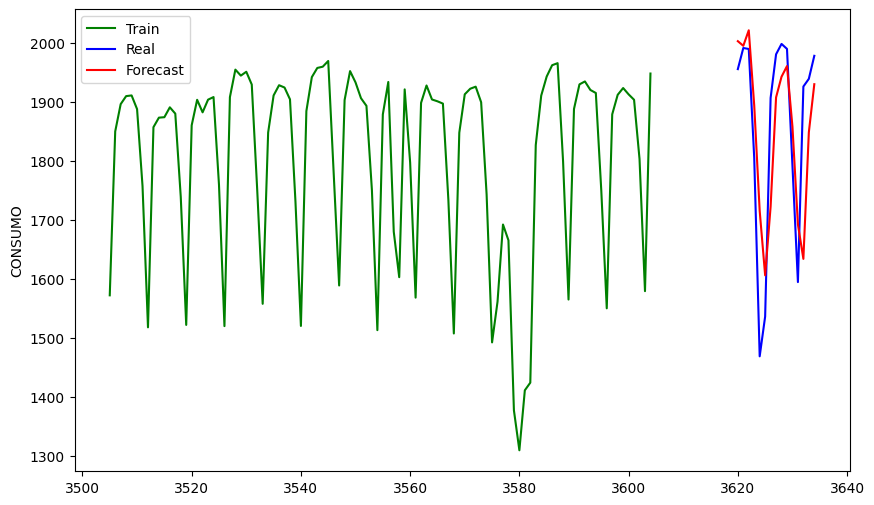

In [1070]:
ax = sns.lineplot(x=train.index[-100:], y=train[-100:], label="Train", color='g')
sns.lineplot(x=to_pred.index, y=to_pred, label="Real", color='b')
sns.lineplot(x=to_pred.index, y=forecast, label="Forecast", color='r')
plt.show()

El MAE aumenta, sin embargo, al analizar graficamente los residuos se puede notar un dato atipico u outlier en el ultimo index del set de testing. Porcentualmente el MAPE se mantiene, por lo que para efectos de la predición y del proceso son aceptables los valores predichos.

### PROPHET (META LIBRARY)

In [1071]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Preparar los datos 
mlp_data = df[['DateTime', 'CONSUMO']].copy()
mlp_data.rename(columns={'DateTime': 'ds', 'CONSUMO': 'y'}, inplace=True)

mlp_data['ds'] = pd.to_datetime(mlp_data['ds'], format='%Y-%m-%d')


len_test = 15
len_val = 15    

train_p = mlp_data[:-(len_val + len_test)].copy()
val_p = mlp_data[-(len_val + len_test):-len_test].copy()
test_p = mlp_data[-len_test:].copy()

# Inicializar el modelo de Prophet
model = Prophet()

# Ajustar el modelo a los datos de entrenamiento
model.fit(train_p)

# Crear un dataframe para las fechas futuras para el conjunto de validación
# En lugar de usar make_future_dataframe, crearemos las fechas manualmente
future_val = pd.DataFrame({'ds': val_p['ds']})

# Hacer predicciones en el conjunto de validación
forecast_val = model.predict(future_val)

# Crear un dataframe para las fechas futuras para el conjunto de prueba
future_test = pd.DataFrame({'ds': test_p['ds']})

# Hacer predicciones en el conjunto de prueba
forecast_test = model.predict(future_test)

18:10:21 - cmdstanpy - INFO - Chain [1] start processing
18:10:21 - cmdstanpy - INFO - Chain [1] done processing


### Validación

In [1072]:
metrics = forecast_accuracy(np.array(forecast_val['yhat']), np.array(val_p['y']),  "val", "PROPHET")
model_summary = pd.concat([model_summary, metrics])
metrics

,model,MAE,MSE,MAPE,RMSE
val,PROPHET,72.658697,8607.773174,0.0399,92.778086


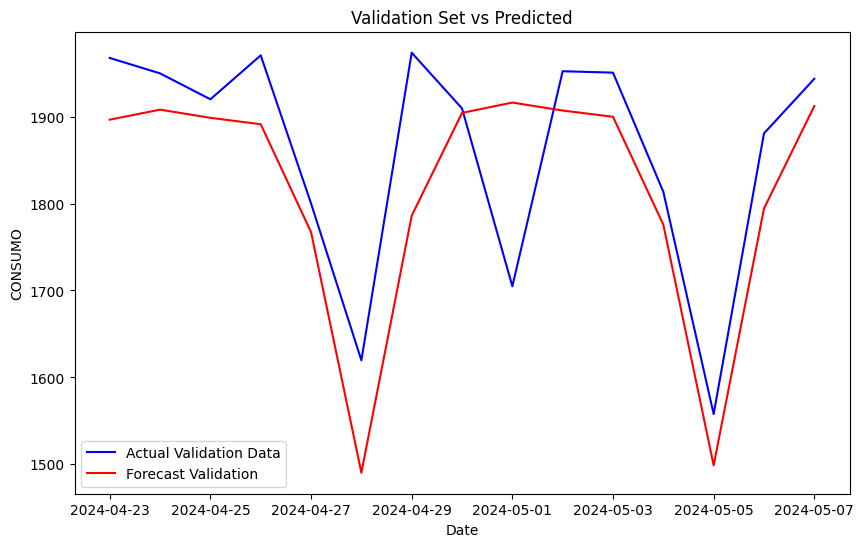

In [1073]:
# Graficar las predicciones del conjunto de validación
plt.figure(figsize=(10, 6))
plt.plot(val_p['ds'], val_p['y'], label='Actual Validation Data', color='blue')
plt.plot(forecast_val['ds'], forecast_val['yhat'], label='Forecast Validation', color='red')
plt.xlabel('Date')
plt.ylabel('CONSUMO')
plt.title('Validation Set vs Predicted')
plt.legend()
plt.show()

### Testing

In [1074]:
metrics = forecast_accuracy(np.array(forecast_test['yhat']), np.array(test_p['y']),  "test",  "PROPHET")
model_summary = pd.concat([model_summary, metrics])
metrics

,model,MAE,MSE,MAPE,RMSE
test,PROPHET,70.216849,8662.670364,0.039372,93.073468


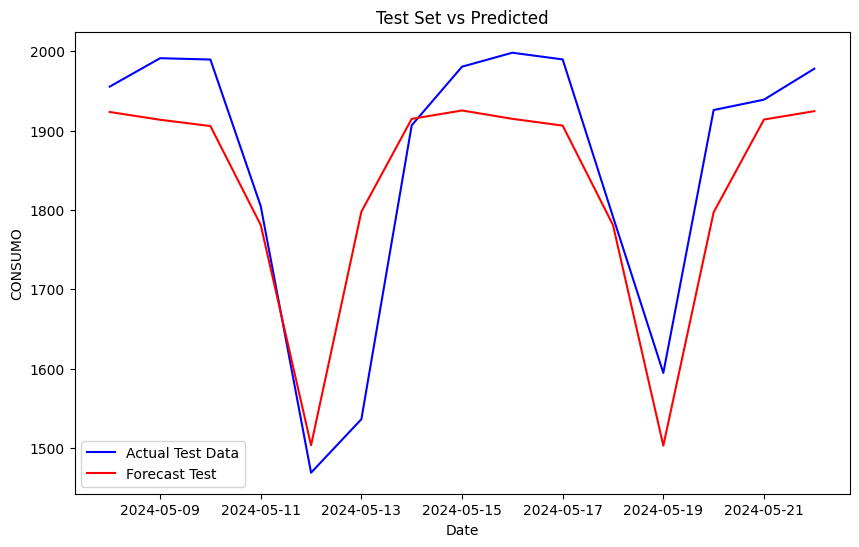

In [1075]:
# Graficar las predicciones del conjunto de prueba
plt.figure(figsize=(10, 6))
plt.plot(test_p['ds'], test_p['y'], label='Actual Test Data', color='blue')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast Test', color='red')
plt.xlabel('Date')
plt.ylabel('CONSUMO')
plt.title('Test Set vs Predicted')
plt.legend()
plt.show()

Se puede observar que usando la líbreria Prophet se tienen errores de MAE y MAPE bajos para los sets de validación y testing.

### MLP (MULTILAYER PERCEPTRON)

### Ajustando Modelo

In [1076]:
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, Dropout
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
# Preparar los datos 
mlp_data = df[['DateTime', 'CONSUMO']].copy()

scaler = MinMaxScaler(feature_range=(0, 1))
mlp_data['scaled_CONSUMO'] = scaler.fit_transform(np.array(mlp_data['CONSUMO']).reshape(-1, 1))



len_test = 15
len_val = 15    

train_p = mlp_data[:-(len_val + len_test)].copy()
val_p = mlp_data[-(len_val + len_test):-len_test].copy()
test_p = mlp_data[-len_test:].copy()

val_p.reset_index(drop=True, inplace=True)
test_p.reset_index(drop=True, inplace=True)

def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        if i-nb_timesteps <= 4:
            print(i-nb_timesteps, i-1, i)
        X.append(list(ts.loc[i-nb_timesteps:i-1])) #Regressors
        y.append(ts.loc[i]) #Target
    X, y = np.array(X), np.array(y)
    return X, y

In [1077]:
X_train, y_train = makeXy(train_p['scaled_CONSUMO'], 7) # se utilizan las observaciones de los últimos siete días para predecir el día siguiente

0 6 7
1 7 8
2 8 9
3 9 10
4 10 11


In [1078]:
print('Shape of train arrays:', X_train.shape, y_train.shape)

Shape of train arrays: (3598, 7) (3598,)


In [1079]:
X_val, y_val = makeXy(val_p['scaled_CONSUMO'], 7)

0 6 7
1 7 8
2 8 9
3 9 10
4 10 11


In [1080]:
X_test, y_test = makeXy(test_p['scaled_CONSUMO'], 7)

0 6 7
1 7 8
2 8 9
3 9 10
4 10 11


In [1081]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from itertools import product

# Crear la función del modelo con parámetros para la búsqueda en cuadrícula
""" def create_mlp_model(hidden_layers=(50,), activation='relu', learning_rate=0.001):
    input_layer = Input(shape=(7,), dtype='float32')  # Tamaño de la capa de entrada especificado como 7
    x = input_layer
    # Agregar las capas ocultas dinámicamente según los parámetros
    for units in hidden_layers:
        x = Dense(units, activation=activation)(x)
    output_layer = Dense(1)(x)  # Capa de salida para predicción de valor continuo
    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer='adam', loss='mse')  # Adam optimiza la tasa de aprendizaje automáticamente
    return model

# Crear el modelo base
mlp_model = KerasRegressor(build_fn=create_mlp_model, epochs=30, batch_size=32, verbose=0)


# Generar el rango de neuronas para cada capa
single_layer_range = [(i,) for i in range(5, 16, 5)]  # Una capa con 10, 20, o 30 neuronas
two_layer_range = [(i, j) for i, j in product(range(5, 16, 5), repeat=2)]  # Dos capas con combinaciones de 10 a 100 neuronas
three_layer_range = [(i, j, k) for i, j, k in product(range(5, 16, 5), repeat=3)]  # Tres capas con 10 a 50 neuronas

# Definir el espacio de parámetros con las capas ocultas generadas automáticamente
param_grid = {
    'hidden_layers': single_layer_range + two_layer_range + three_layer_range,
    'activation': ['relu', 'tanh'],
    'learning_rate': [0.001, 0.01]
}

# Crear un divisor de series de tiempo
tscv = TimeSeriesSplit(n_splits=3)  # Ajusta el número de splits según la cantidad de datos

# Configurar GridSearchCV con TimeSeriesSplit
grid_search = GridSearchCV(estimator=mlp_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=1)

# Entrenar el modelo con los datos
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:", grid_search.best_params_) """


' def create_mlp_model(hidden_layers=(50,), activation=\'relu\', learning_rate=0.001):\n    input_layer = Input(shape=(7,), dtype=\'float32\')  # Tamaño de la capa de entrada especificado como 7\n    x = input_layer\n    # Agregar las capas ocultas dinámicamente según los parámetros\n    for units in hidden_layers:\n        x = Dense(units, activation=activation)(x)\n    output_layer = Dense(1)(x)  # Capa de salida para predicción de valor continuo\n    model = Model(inputs=input_layer, outputs=output_layer)\n    \n    model.compile(optimizer=\'adam\', loss=\'mse\')  # Adam optimiza la tasa de aprendizaje automáticamente\n    return model\n\n# Crear el modelo base\nmlp_model = KerasRegressor(build_fn=create_mlp_model, epochs=30, batch_size=32, verbose=0)\n\n\n# Generar el rango de neuronas para cada capa\nsingle_layer_range = [(i,) for i in range(5, 16, 5)]  # Una capa con 10, 20, o 30 neuronas\ntwo_layer_range = [(i, j) for i, j in product(range(5, 16, 5), repeat=2)]  # Dos capas con 

In [1082]:
#Ahora definimos la red MLP utilizando la API funcional de Keras. En este enfoque una capa puede ser declarada como la entrada de la siguiente capa en el momento de definir la siguiente
from tensorflow.keras.optimizers import Adam

input_layer = Input(shape=(7,), dtype='float32')

#Primera iteracion
""" dense1 = Dense(32, activation='tanh')(input_layer)
dense2 = Dense(16, activation='tanh')(dense1)
dense3 = Dense(16, activation='tanh')(dense2)
 """

#Primera iteracion
dense1 = Dense(15, activation='relu')(input_layer)
dense2 = Dense(10, activation='relu')(dense1)
dense3 = Dense(5, activation='relu')(dense2)


#Tercera iteracion
""" dense1 = Dense(50, activation='relu')(input_layer)
dense2 = Dense(50, activation='relu')(dense1) """


dropout_layer = Dropout(0.2)(dense3)
output_layer = Dense(1, activation='linear')(dropout_layer)
optimizer = Adam(learning_rate=0.001)

ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_squared_error', optimizer=optimizer)
ts_model.summary()

Model: "model_1257"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1255 (InputLayer)     [(None, 7)]               0         
                                                                 
 dense_4049 (Dense)          (None, 15)                120       
                                                                 
 dense_4050 (Dense)          (None, 10)                160       
                                                                 
 dense_4051 (Dense)          (None, 5)                 55        
                                                                 
 dropout_26 (Dropout)        (None, 5)                 0         
                                                                 
 dense_4052 (Dense)          (None, 1)                 6         
                                                                 
Total params: 341
Trainable params: 341
Non-trainable pa

In [1083]:
save_weights_at = os.path.join('keras_models', 'PRSA_data_Air_Pressure_MLP_weights.{epoch:02d}-{val_loss:.4f}.keras')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch');

In [1084]:
import os
from joblib import dump, load

history_airp = None

if os.path.exists('history_airp.joblib'):
    history_airp = load('history_airp.joblib')
    print("El archivo 'history_airp.joblib' ya existe. Se ha cargado el historial del entrenamiento.")
else:
    history_airp = ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=2, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True);
    dump(history_airp.history, 'history_airp.joblib')
    print("El entrenamiento se ha completado y el historial ha sido guardado en 'history_airp.joblib'.")

El archivo 'history_airp.joblib' ya existe. Se ha cargado el historial del entrenamiento.


In [1085]:
import os
import re
from tensorflow.keras.models import load_model

model_dir = 'keras_models'
files = os.listdir(model_dir)
pattern = r"PRSA_data_Air_Pressure_MLP_weights\.(\d+)-([\d\.]+)\.keras"

best_val_loss = float('inf')
best_model_file = None
best_model = None

for file in files:
    match = re.match(pattern, file)
    if match:
        epoch = int(match.group(1))
        val_loss = float(match.group(2))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_file = file

if best_model_file:
    best_model_path = os.path.join(model_dir, best_model_file)
    print(f"Cargando el mejor modelo: {best_model_file} con val_loss: {best_val_loss}")
    best_model = load_model(best_model_path)
else:
    print("No se encontraron archivos de modelos que coincidan con el patrón.")

Cargando el mejor modelo: PRSA_data_Air_Pressure_MLP_weights.11-0.0061.keras con val_loss: 0.0061


### Validación

In [1086]:
preds = best_model.predict(X_val)
pred_consumo = scaler.inverse_transform(preds)
pred_consumo = np.squeeze(pred_consumo)

1/1 [==============================] - 0s 38ms/step


In [1087]:
r2 = r2_score(val_p['CONSUMO'].loc[7:], pred_consumo)
print('R-squared for the validation set:', round(r2,4))

R-squared for the validation set: 0.4061


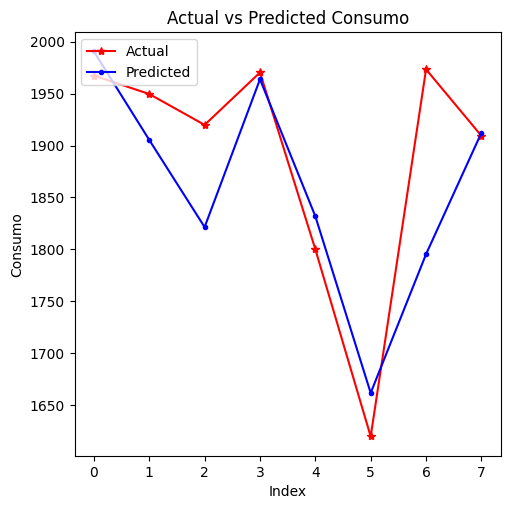

In [1088]:
val_ff = val_p[:8] #Valores reales de validacion
plt.figure(figsize=(5.5, 5.5))
plt.plot(val_ff['CONSUMO'], linestyle='-', marker='*', color='r')
plt.plot(pred_consumo, linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Consumo')
plt.ylabel('Consumo')
plt.xlabel('Index');

In [1089]:
metrics = forecast_accuracy(np.array(pred_consumo),np.array(val_ff['CONSUMO']),  "val",  "MLP")
model_summary = pd.concat([model_summary, metrics])
metrics

,model,MAE,MSE,MAPE,RMSE
val,MLP,53.429561,5845.753417,0.028068,76.457527


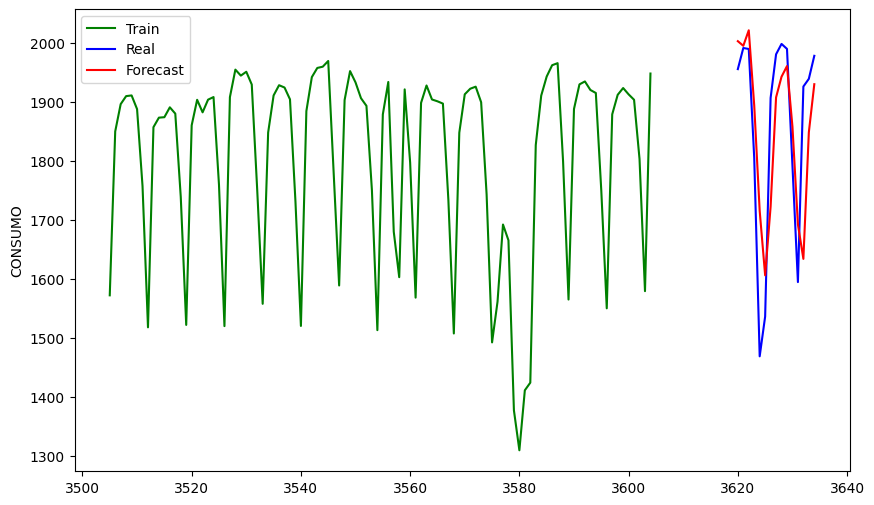

In [1090]:
ax = sns.lineplot(x=train.index[-100:], y=train[-100:], label="Train", color='g')
sns.lineplot(x=to_pred.index, y=to_pred, label="Real", color='b')
sns.lineplot(x=to_pred.index, y=forecast, label="Forecast", color='r')
plt.show()

Se puede observar que este modelo tiene un MAE y MAPE relativamente bajos en el set de validación

### Testing

In [1091]:
preds = best_model.predict(X_test)
pred_consumo = scaler.inverse_transform(preds)
pred_consumo = np.squeeze(pred_consumo)

r2 = r2_score(val_p['CONSUMO'].loc[7:], pred_consumo)
print('R-squared for the validation set:', round(r2,4))

1/1 [==============================] - 0s 17ms/step
R-squared for the validation set: -0.0331


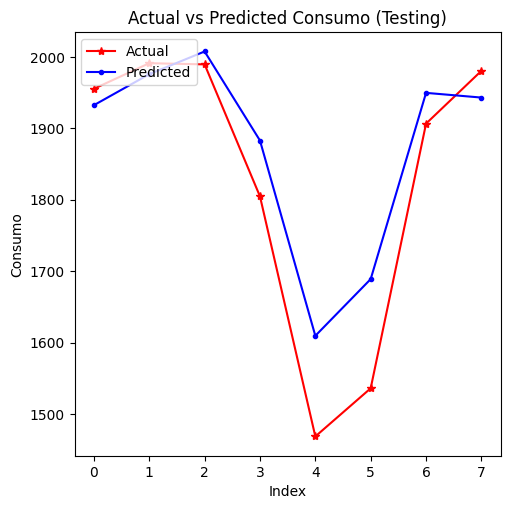

In [1092]:
val_ff = test_p[:8]
plt.figure(figsize=(5.5, 5.5))
plt.plot(val_ff['CONSUMO'], linestyle='-', marker='*', color='r')
plt.plot(pred_consumo, linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Consumo (Testing)')
plt.ylabel('Consumo')
plt.xlabel('Index');

In [1093]:
metrics = forecast_accuracy(np.array(pred_consumo),np.array(val_ff['CONSUMO']),  "test",  "MLP")
model_summary = pd.concat([model_summary, metrics])
metrics

,model,MAE,MSE,MAPE,RMSE
test,MLP,63.629166,6713.91164,0.038613,81.938463


Inclusive para el conjunto de testing, el modelo disminuye los valores del MAE y MAPE

### LSTM 

In [1094]:
#El número de pasos de tiempo es siete y el número de muestras es el mismo que el número de muestras en X_train y X_val, que se transforman a arreglos 3D

X_train, X_val = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
print('Shape of 3D arrays:', X_train.shape, X_val.shape)  

Shape of 3D arrays: (3598, 7, 1) (8, 7, 1)


In [1099]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import numpy as np
from itertools import product

# Crear la función del modelo con parámetros para la búsqueda en cuadrícula
def create_lstm_model(hidden_units=(50,), activation='tanh', learning_rate=0.001):
    input_layer = Input(shape=(7, 1), dtype='float32')  # La capa de entrada se ajusta a (7, 1) para series de tiempo
    x = input_layer
    # Agregar las capas LSTM dinámicamente según los parámetros
    for units in hidden_units[:-1]:  # Todas menos la última capa LSTM
        x = LSTM(units, activation=activation, return_sequences=True)(x)
    x = LSTM(hidden_units[-1], activation=activation)(x)  # Última capa LSTM sin secuencias
    output_layer = Dense(1)(x)  # Capa de salida para predicción de valor continuo
    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(optimizer='adam', loss='mse')
    return model

# Crear el modelo base
lstm_model = KerasRegressor(build_fn=create_lstm_model, epochs=30, batch_size=32, verbose=0)

# Generar el rango de neuronas para cada capa
single_layer_range = [(i,) for i in range(10, 21, 10)]  # Una capa con 10, 20, o 30 neuronas
two_layer_range = [(i, j) for i, j in product(range(10, 21, 10), repeat=2)]  # Dos capas con combinaciones de 10 a 40 neuronas
three_layer_range = [(i, j, k) for i, j, k in product(range(5, 16, 10), repeat=3)]  # Tres capas con 5 a 30 neuronas

# Definir el espacio de parámetros con las capas ocultas generadas automáticamente
param_grid = {
    'hidden_units': single_layer_range + two_layer_range + three_layer_range,
    'activation': ['tanh', 'relu'],
    'learning_rate': [0.001, 0.01]
}

# Crear un divisor de series de tiempo
tscv = TimeSeriesSplit(n_splits=3)

# Configurar GridSearchCV con TimeSeriesSplit
grid_search = GridSearchCV(estimator=lstm_model, param_grid=param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=1)

# Asegúrate de que X_train esté en la forma (n_samples, timesteps, features)
# Por ejemplo, X_train.reshape(-1, 7, 1) si X_train tiene forma (n_samples, 7)
#X_train = np.array(X_train).reshape(-1, 7, 1)  # Ajusta según tus datos de entrada
#y_train = np.array(y_train)  # Asegúrate de que y_train esté en formato de array

# Entrenar el modelo con los datos
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:", grid_search.best_params_)

KeyboardInterrupt: 

In [ ]:
input_layer = Input(shape=(7,1), dtype='float32')
lstm_layer1 = LSTM(64, input_shape=(7,1), return_sequences=True)(input_layer)
lstm_layer2 = LSTM(32, input_shape=(7,64), return_sequences=False)(lstm_layer1)
dropout_layer = Dropout(0.2)(lstm_layer2)
output_layer = Dense(1, activation='linear')(dropout_layer)
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_absolute_error', optimizer='adam') #SGD(lr=0.001, decay=1e-5))
ts_model.summary()

In [ ]:
save_weights_at = os.path.join('keras_models', 'PRSA_data_PM2.5_LSTM_weights.{epoch:02d}-{val_loss:.4f}.keras')
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch')

In [ ]:
history_pm25_LSTM = None

if os.path.exists('history_pm25_LSTM.joblib'):
    history_pm25_LSTM = load('history_pm25_LSTM.joblib')
    print("El archivo 'history_pm25_LSTM.joblib' ya existe. Se ha cargado el historial del entrenamiento.")
else:
    history_pm25_LSTM = ts_model.fit(x=X_train, y=y_train, batch_size=16, epochs=20,
             verbose=2, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True);
    dump(history_pm25_LSTM.history, 'history_pm25_LSTM.joblib')
    print("El entrenamiento se ha completado y el historial ha sido guardado en 'history_pm25_LSTM.joblib'.")

In [ ]:
model_dir = 'keras_models'
files = os.listdir(model_dir)
pattern = r"PRSA_data_PM2.5_LSTM_weights\.(\d+)-([\d\.]+)\.keras"
    
best_val_loss = float('inf')
best_model_file = None
best_model = None

for file in files:
    match = re.match(pattern, file)
    if match:
        epoch = int(match.group(1))
        val_loss = float(match.group(2))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_file = file

if best_model_file:
    best_model_path = os.path.join(model_dir, best_model_file)
    print(f"Cargando el mejor modelo: {best_model_file} con val_loss: {best_val_loss}")
    best_model = load_model(best_model_path)
else:
    print("No se encontraron archivos de modelos que coincidan con el patrón.")

### Validacion

In [ ]:
preds = best_model.predict(X_val)
pred_consumo = scaler.inverse_transform(preds)
pred_consumo = np.squeeze(pred_consumo)
r2 = r2_score(val_p['CONSUMO'].loc[7:], pred_consumo)
print('R-squared for the validation set:', round(r2,4))

In [ ]:
val_ff = val_p[:8]
plt.figure(figsize=(5.5, 5.5))
plt.plot(val_ff['CONSUMO'], linestyle='-', marker='*', color='r')
plt.plot(pred_consumo, linestyle='-', marker='.', color='b')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Consumo')
plt.ylabel('Consumo')
plt.xlabel('Index');

In [ ]:
metrics = forecast_accuracy(np.array(pred_consumo),np.array(val_ff['CONSUMO']),  "val",  "LSTM")
#model_summary = pd.concat([model_summary, metrics])
metrics

## RESULTADOS

In [1096]:
model_summary[model_summary.index == 'val']

,model,MAE,MSE,MAPE,RMSE
val,SSE,95.868582,22635.261372,0.056539,150.450196
val,ARIMA_NO_ROLLING,91.592126,14909.387039,0.051193,122.104001
val,ARIMA_ROLLING,100.340050,15080.678944,0.055073,122.803416
val,PROPHET,72.658697,8607.773174,0.039900,92.778086
val,MLP,53.429561,5845.753417,0.028068,76.457527


In [1097]:
model_summary[model_summary.index == 'test']

,model,MAE,MSE,MAPE,RMSE
test,SSE,123.833780,36805.832010,0.075663,191.848461
test,ARIMA_NO_ROLLING,100.278742,16553.632330,0.058523,128.660920
test,ARIMA_ROLLING,95.053896,15337.183134,0.053473,123.843381
test,PROPHET,70.216849,8662.670364,0.039372,93.073468
test,MLP,63.629166,6713.911640,0.038613,81.938463
